# This notebook contains the methodology to create historical S&P500 constituents, mapping old tickers, and obtaining all data
1. Historical constituents are taken from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
1. We first obtained price data from yahoo finance (tickers that are still listed on the exchange, or tickers are valid)
1. For data we were not able to scrape from yahoo finance, it is because the company has been delisted, or the ticker and company name has changed (because of company rebranding in the case of FB changing to META, to bigger companies acquiring smaller companies)
1. For delisted companies, we downloaded the company data manually from https://www.investing.com/, due to the lack of availability of an API, and because investing.com data is provided free of charge
1. Our research period will be from 2010-01-01 to 2023-02-10. For the period, our historically accurate s&p500 constituents has an average of 498 constituents available at any point in time, compared to using just the latest 500 list (only 300 survived from 2010-01-01). Thurs, this removes survivorship bias from our research, lending more credibility to our results.
1. In total, we were able to acquire data for 743 tickers out of 752 tickers that we required. We were only unable to obtain data of the following 9 tickers: ["CEPH","CTXS","MHS","NOVL","TYC","TNL","XTO", "PCS", "BJS"]

In [1]:
import pandas as pd

We will start with current s&p500 and walk backwards in history, removing and adding where necessary

In [2]:
# Historical changes from Wikipedia
sp500_changes = pd.read_csv("../data/sp500_changes.csv")
sp500_changes["Date"] = pd.to_datetime(sp500_changes["Date"], format="%B %d, %Y")

# Current S&P500 Constituents
sp500_current = pd.read_csv("../data/sp500_current.csv")

# Clean up some missing data
sp500_current["Date Added"] = sp500_current["Date Added"].replace("2009", "01-01-2009")
sp500_current["Date Added"] = sp500_current["Date Added"].fillna("01-01-2000")
sp500_current["Date Added"] = sp500_current["Date Added"].apply(lambda x: x.replace("/", "-"))
sp500_current["Date Added"] = pd.to_datetime(sp500_current["Date Added"], format="%d-%m-%Y")

# To keep track of what is in the index
sp500_current["is_included"] = 1

# Visualize Data

In [3]:
sp500_changes.head()

,Date,Added Ticker,Added Security,Removed Ticker,Removed Security,Reason
0,2023-01-05,NaN,NaN,VNO,Vornado Realty Trust,Market capitalization change.[4]
1,2023-01-04,GEHC,GE HealthCare,NaN,NaN,S&P 500 constituent General Electric spun off ...
2,2022-12-22,STLD,Steel Dynamics,ABMD,Abiomed,S&P 500 constituent Johnson & Johnson acquired...
3,2022-12-19,FSLR,First Solar,FBHS,Fortune Brands Home & Security,Market capitalization change.[7]
4,2022-12-19,NaN,NaN,MBC,MasterBrand,Market capitalization change.[7]


Here we can see that added and removed are in different columns

In [4]:
sp500_current.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters,Date Added,CIK,Founded,is_included
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,1
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,1
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,1
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),1
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,1


In [5]:
# Added and Removed have different columns. Separate into two dataframes
added_changes = sp500_changes[sp500_changes["Added Ticker"].notna()][["Date", "Added Ticker", "Added Security"]].copy()
added_changes.columns = ["Date Added", "Symbol", "Security"]

removed_changes = sp500_changes[sp500_changes["Removed Ticker"].notna()][["Date", "Removed Ticker", "Removed Security"]].copy()
removed_changes.columns = ["Date Removed", "Symbol", "Security"]

In [6]:
# Some have been added and are still in the S&P500 list
added_changes[added_changes.Symbol.isin(sp500_current.Symbol)].shape

(211, 3)

In [7]:
# These were added, and have since been removed
added_but_removed = added_changes[~added_changes.Symbol.isin(sp500_current.Symbol)].copy()
added_but_removed.shape

(100, 3)

In [8]:
# We don't have the date at which these were added. We should backfill these later
removed_changes[~(removed_changes.Symbol.isin(sp500_current.Symbol) | removed_changes.Symbol.isin(added_changes.Symbol))]

,Date Removed,Symbol,Security
0,2023-01-05,VNO,Vornado Realty Trust
8,2022-10-03,CTXS,Citrix Systems
13,2022-06-21,UAA,Under Armour
16,2022-04-04,PBCT,People's United Financial
18,2022-02-15,XLNX,Xilinx
...,...,...,...
315,1999-06-09,HPH,Harnischfeger Industries
316,1998-12-11,LDW,Amoco
317,1998-12-11,GRN,General Re
318,1998-12-11,SUN,SunAmerica


Some symbols were added, and then removed at some point in history (not in S&P500 currently). We need to track reasons why

In [9]:
unaccounted_for_symbols = added_but_removed[~added_but_removed.Symbol.isin(removed_changes.Symbol)]
unaccounted_for_symbols.reset_index(drop=True)

,Date Added,Symbol,Security
0,2016-01-05,WLTW,Willis Towers Watson
1,2014-08-06,DISCK,Discovery Communications
2,2013-12-23,FB,Facebook
3,2013-11-13,KORS,Michael Kors
4,2012-12-21,DLPH,Delphi Automotive
5,2011-02-25,JOYG,Joy Global
6,2009-11-03,PCLN,Priceline.com
7,2008-09-16,HRS,Harris Corporation
8,2008-06-23,COG,Cabot Oil & Gas
9,2007-10-26,JEC,Jacobs Engineering Group


Here we document every single discrepancy
1. WLTW typo, should be WTW, we will remove, already in sp500
1. DISCK is special handling, can remove
1. Facebook has been renamed to Meta, so we ignore this
1. KORS was renamed to CPRI ############WE NEED THIS
1. DLPH renamed to APTV
1. JOYG is JOY ###### WE NEED THIS
1. PCLN renamed to BKNG
1. HRS renamed to LHX
1. COG renamed to CTRA
1. JEC renamed to J
1. TSO was renamed to ANDV ###### WE NEED THIS
1. LUK renamed to JEF ###### WE NEED THIS
1. KFT renamed to KHC
1. WLP renamed to ELV
1. Firstar delisted (outside of our backtest, so it's safe to remove)

### These are still in the s&p500, just renamed

In [10]:
# These are still in the s&p500, just renamed
sp500_current[sp500_current.Symbol.isin(["WTW", "APTV", "BKNG", "LHX", "CTRA", "J", "ELV"])]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters,Date Added,CIK,Founded,is_included
46,APTV,Aptiv,Consumer Discretionary,Auto Parts & Equipment,"Dublin, Ireland",2012-12-24,1521332,1994,1
72,BKNG,Booking Holdings,Consumer Discretionary,Internet & Direct Marketing Retail,"Norwalk, Connecticut",2009-11-06,1075531,1996,1
133,CTRA,Coterra,Energy,Oil & Gas Exploration & Production,"Houston, Texas",2008-06-23,858470,2021 (1989),1
169,ELV,Elevance Health,Health Care,Managed Health Care,"Indianapolis, Indiana",2002-07-25,1156039,2014 (1946),1
265,J,Jacobs Solutions,Industrials,Construction & Engineering,"Dallas, Texas",2007-10-26,52988,1947,1
280,LHX,L3Harris,Industrials,Aerospace & Defense,"Melbourne, Florida",2008-09-22,202058,2019 (1895),1
493,WTW,Willis Towers Watson,Financials,Insurance Brokers,"London, United Kingdom",2016-01-05,1140536,2016,1


1. KORS was renamed to CPRI
2. JOYG is JOY
3. TSO was renamed to ANDV
4. LUK renamed to JEF

In [11]:
# We will need to account for the addition and removal of these
removed_changes[removed_changes.Symbol.isin(["CPRI", "JOY", "ANDV", "JEF"])]

,Date Removed,Symbol,Security
52,2020-05-12,CPRI,Capri Holdings
68,2019-09-26,JEF,Jefferies Financial Group
90,2018-10-01,ANDV,Andeavor
169,2015-10-07,JOY,Joy Global


# Great all tickers have been accounted for

In [12]:
added_changes = added_changes[~added_changes.Symbol.isin(unaccounted_for_symbols.Symbol)].copy()

We now know how to account for "CPRI", "JOY", "ANDV", "JEF". We already have the removed dates. Now we add in the Date Added dates.

In [13]:
# KORS was renamed to CPRI # WE NEED THIS
# JOYG is JOY # WE NEED THIS
# TSO was renamed to ANDV # WE NEED THIS
# LUK renamed to JEF # WE NEED THIS
edited_changes = pd.DataFrame({"Date Added":["2013-11-13", "2011-02-25", "2007-09-27", "2007-08-24"],
             "Symbol":["CPRI", "JOY", "ANDV", "JEF"],
             "Security":["Capri Holdings", "Joy Global", "Andeavor", "Jefferies Financial Group"]})
edited_changes["Date Added"] = pd.to_datetime(edited_changes["Date Added"])
added_changes = pd.concat([added_changes, edited_changes])

In [14]:
added_changes.shape

(300, 3)

In [15]:
# Now, added changes have to be completely within s&p500 and in added_changes
print(added_changes[added_changes.Symbol.isin(list(sp500_current.Symbol.values) + list(removed_changes.Symbol.values))].shape)

(300, 3)


# Data Preprocessing is Completed, now we create the master sheet

In [16]:
import numpy as np
# These are current s&p500, no date removed
sp500_current["Date Removed"] = np.nan
sp500_current.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters,Date Added,CIK,Founded,is_included,Date Removed
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,1,NaN
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,1,NaN
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,1,NaN
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),1,NaN
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,1,NaN


Create a mapping of symbol security, to wikipedia ticker

In [17]:
# Combine current s&p, historical additions and changes
# This is to map Symbol to Security to Wikipedia ticker
symbol_security_map = pd.concat([sp500_current[["Symbol", "Security", "GICS Sector", "GICS Sub-Industry", "CIK"]], 
                                 added_changes[["Symbol", "Security"]], 
                                 removed_changes[["Symbol", "Security"]]])
symbol_security_map = symbol_security_map.groupby("Symbol").first().reset_index()

In [18]:
# This is the ticker registered on the wikipedia page
symbol_security_map["wiki_ticker"] = symbol_security_map["Symbol"]

In [19]:
symbol_security_map.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,CIK,wiki_ticker
0,A,Agilent Technologies,Health Care,Health Care Equipment,1090872.0,A
1,AA,Alcoa Inc,None,None,NaN,AA
2,AAL,American Airlines Group,Industrials,Airlines,6201.0,AAL
3,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail,1158449.0,AAP
4,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",320193.0,AAPL


# Now, we walk back in time

In [20]:
start_date = min(sp500_current["Date Added"].min(), added_changes["Date Added"].min())
end_date = pd.to_datetime("2023-02-11") # End date of our backtest

In [21]:
entire_date_range = pd.date_range(start=start_date, end=end_date)
entire_date_range = pd.DataFrame(entire_date_range)
entire_date_range.columns = ["Date Added"]

In [22]:
# Adding in dummy symbol. We want the end date to be 2023-02-11, so adding this here first
sp500_current = pd.concat([sp500_current, pd.DataFrame({"Symbol":"temp", "Date Added":[pd.to_datetime("2023-02-11")]})])

In [23]:
sp500_current.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters,Date Added,CIK,Founded,is_included,Date Removed
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740.0,1902,1.0,NaN
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142.0,1916,1.0,NaN
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800.0,1888,1.0,NaN
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152.0,2013 (1888),1.0,NaN
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373.0,1989,1.0,NaN


In [24]:
# Now we pivot and resample daily. Recall we wanted temp to fix the last date as 2023-02-11
sp500_current = sp500_current.pivot(index="Date Added", columns = "Symbol", values="is_included").resample("d").mean()
# Now we can drop temp
sp500_current = sp500_current.drop(columns="temp").ffill()

There are all the current constituents, so 2023-02-11 will be all filled with 1s. 1 meaning it's in the s&p500

In [25]:
sp500_current.tail()

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date Added,,,,,,,,,,,,,,,,,,,,,
2023-02-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-02-08,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-02-09,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-02-10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-02-11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


It will be 1 only from the date at which it was added

In [26]:
sp500_current.head()

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date Added,,,,,,,,,,,,,,,,,,,,,
1957-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Now our sp500 only contains the latest
sp500_current_count_over_time = sp500_current.sum(axis=1)

In [28]:
sp500_current_count_over_time.head()

Date Added
1957-03-04    37.0
1957-03-05    37.0
1957-03-06    37.0
1957-03-07    37.0
1957-03-08    37.0
Freq: D, dtype: float64

In [29]:
added_changes["is_included"] = 1
added_changes = pd.concat([added_changes, pd.DataFrame({"Symbol":"temp", "Date Added":[pd.to_datetime("2023-02-11"), pd.to_datetime("1957-03-04")]})])
added_changes = added_changes.pivot(index="Date Added", columns = "Symbol", values="is_included").resample("d").mean()
added_changes = added_changes.drop(columns="temp")

### We don't ffill here. This just contains a single instance of 1, the date at which it was added
### Note that we have to handle it this way because a stock might have been added (and removed) multiple times

In [30]:
added_changes.head()

Symbol,AAL,AAP,ABBV,ABK,ABMD,ACGL,ACN,ADS,ADT,AJG,...,WAB,WCG,WPX,WRB,WST,XEC,XYL,YHOO,ZBRA,ZTS
Date Added,,,,,,,,,,,,,,,,,,,,,
1957-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [32]:
historical_sp500 = sp500_current.copy()

for col in added_changes.columns:
    if col in historical_sp500:
        # We want to preserve the NaNs
        # Concatenate and then we sum up for each date
        # min_count=1 will preserve the NaNs
        # We will need to fill forward later, also considering that there are removed dates
        historical_sp500[col] = pd.concat([historical_sp500[col].copy(), 
                                           added_changes[col].copy()], axis=1).sum(axis=1, min_count=1)
    else:
        # Else we can just simple add it in. We'll need to fill forward later
        historical_sp500[col] = added_changes[col]

In [33]:
historical_sp500.shape

(24086, 591)

In [34]:
# This only contains the precise date when it's removed. 0 where it's removed.
removed_changes["is_included"] = 0
removed_changes = pd.concat([removed_changes, pd.DataFrame({"Symbol":"temp", "Date Removed":[pd.to_datetime("2023-02-11"), pd.to_datetime("1957-03-04")]})])
removed_changes = removed_changes.pivot(index="Date Removed", columns = "Symbol", values="is_included").resample("d").mean()
removed_changes = removed_changes.drop(columns="temp")
removed_changes.head()

Symbol,AA,ABK,ABMD,ABS,ACAS,ACE,ADS,ADT,AET,AGN,...,WPX,WU,WYN,X,XEC,XL,XLNX,XRX,XTO,YHOO
Date Removed,,,,,,,,,,,,,,,,,,,,,
1957-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# 0 on the day it was removed. We want it to be 1 on the last day it was in the index, and backfill
removed_were_added = removed_changes.shift(-1).copy()
removed_were_added.dropna(how="all")
removed_were_added = (removed_were_added == 0) * 1 # Last date 
removed_were_added = removed_were_added.replace(0, np.nan)
removed_were_added = removed_were_added.bfill().fillna(0)

In [36]:
for col in removed_changes.columns:
    if col in historical_sp500:
        historical_sp500[col] = pd.concat([historical_sp500[col].copy(), 
                                           removed_changes[col].copy()], axis=1).sum(axis=1, min_count=1)
    else:
        historical_sp500[col] = removed_were_added[col]

In [37]:
historical_sp500 = historical_sp500.ffill().fillna(0)

Text(0.5, 0, 'Date')

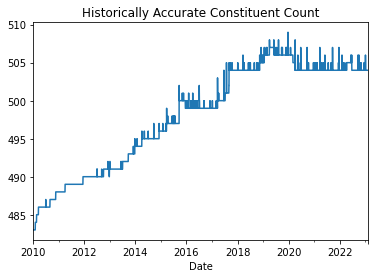

In [38]:
import matplotlib.pyplot as plt
historical_sp500.sum(axis=1).loc["2010-01-01":].plot()
plt.title("Historically Accurate Constituent Count")
plt.xlabel("Date")

Text(0, 0.5, 'Count of Companies')

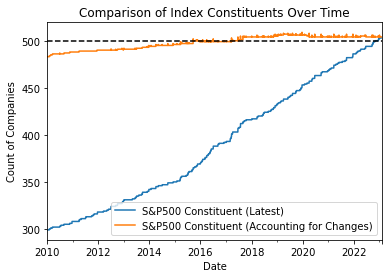

In [39]:
sp500_current_count_over_time.loc["2010-01-01":].plot(label="S&P500 Constituent (Latest)")
historical_sp500.sum(axis=1).loc["2010-01-01":].plot(label="S&P500 Constituent (Accounting for Changes)")
plt.axhline(500, ls="--", color="black")
plt.legend()
plt.title("Comparison of Index Constituents Over Time")
plt.xlabel("Date")
plt.ylabel("Count of Companies")

In [40]:
print("Latest: ", sp500_current_count_over_time.loc["2010-01-01":].mean())
print("Historically Accurate: ", historical_sp500.sum(axis=1).loc["2010-01-01":].mean())

Latest:  390.4521920668058
Historically Accurate:  497.9795407098121


# Scraping Market Data
We first scrape all we can from yahoo finance

In [199]:
import yfinance as yf
import time
from tqdm.notebook import tqdm

failed_tickers = []
for ticker in tqdm(historical_sp500.columns):
    price_dataframe = yf.download(ticker)
    if price_dataframe.shape[0] == 0:
        failed_tickers.append(ticker)
        print(f"{ticker} failed")
    else:
        price_dataframe.reset_index().to_csv(f"../data/market_data/{ticker}.csv", index=True)

  0%|          | 0/791 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CAM: 1d data not available for startTime=-2208994789 and endTime=1676184510. Only 100 years worth of day granularity data are allowed to be fetched per request.
CAM failed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CELG: No timezone found, symbol may be delisted
CELG failed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CEPH: 1d data not available for startTime=-2208994789 and endTime=1676184512. Only 100 years worth of day granularity data are allowed to be fetched per request.
CEPH failed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SNDK: 1d data not available for startTime=-2208994789 and endTime=1676184575. Only 100 years worth of day granularity data are allowed to be fetched per request.
SNDK failed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SPLS: 1d data not available for startTime=-2208994789 and endTime=1676184576. Only 100 years worth of day granularity data are allowed to be fetched per request.
SPLS failed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- STI: No timezone found, symbol may be delisted
STI failed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- STJ: 1d data not available for startTime=-2208994789 and endTime=1676184576. Only 100 years 

We have scrapped all possible data from yahoo finance. We now move on to obtaining delisted tickers from investing.com. Due to lack of API, we have to donwload individually from https://www.investing.com/. We have also found out that numerous tickers have been renamed, and document it as such.

In [35]:
# ACAS renamed to AMBKP
# ADS Alliance Data Systems renamed to Bread Financial Holdings Inc (BFH)
# BRCM renamed to AVGO
# CEPH cannot find anywhere, exclude
# CTXS cannot find
# CMCSK is CMCSA
# DNR renamed to DEN
# DPS renamed to KDP
# DWDP to DD
# EK to KODK
# ENDP TO ENDPQ
# ESV to VALPQ 
# FII to FHI
# FNM to FNMA
# FRE to FMCC
# FTR to FYBR
# GENZ to SNY, Sanofi 
# GGP to BPYU Brookfield Property Reit
# JCP to CPPRQ
# FRX to BODY
# LEH out of backtest, lehman
# NOVL cannot find
# JDSU to VIAV
# KRFT to KHC
# MHS cannot find
# MIL renamed to Scully Royalty Ltd (SRL)
# NVLS	Novellus Systems to Alpine Immune Sciences Inc (ALPN)
# PGN to PGNPQ
# Q QuintilesIMS renamed to IQV (NYSE)
# TSS	TSYS	to TSYS
# XTO can remove, out of backtest period
# TYC	Tyco International	 to NXGEF_old, BUT NO PRICE CANNOT FIND
# VIAB	Viacom to Paramount Global Class B (PARA)
# WIN to WINMQ
# WYN to Travel + Leisure Co (TNL)
# XL to XL Group Ltd (XL_old)
# YHOO to Altaba Inc (AABA)

no_data = ["CEPH","CTXS","MHS","NOVL","TYC","TNL","XTO", "PCS", "BJS"]

# wikipedia : new symbol
map_to_new_ticker = {"ACAS": "AMBKP",
"ADS": "BFH", # Bread Financial Holdings Inc ()
"BRCM": "AVGO",
"CMCSK": "CMCSA",
"DNR": "DEN",
"DPS": "KDP",
"DWDP": "DD",
"EK": "KODK",
"ENDP": "ENDPQ",
"ESV" : "VALPQ",
"FII": "FHI",
"FNM": "FNMA",
"FRE": "FMCC",
"FTR": "FYBR",
"GENZ" : "SNY", # Sanofi
"GGP": "BPYU", # Brookfield Property Reit
"JCP": "CPPRQ",
"FRX": "BODY",
"JDSU": "VIAV",
"KRFT": "KHC",
"MIL": "SRL", # Scully Royalty Ltd
"NVLS": "ALPN", # Alpine Immune Sciences Inc
"PGN": "PGNPQ",
"Q": "IQV",
"TSS": "TSYS",
"VIAB": "PARA", # Paramount Global Class B
"WIN" : "WINMQ",
"WYN": "TNL", # Leisure Co
"YHOO" : "AABA"} # Altaba Inc ()

In [36]:
symbol_security_map["new_ticker"] = symbol_security_map["Symbol"]

Map over new ticker

In [37]:
symbol_security_map["new_ticker"] = symbol_security_map["new_ticker"].apply(lambda x: x if x not in map_to_new_ticker else map_to_new_ticker[x])

In [38]:
# Example of new ticker
symbol_security_map[symbol_security_map["Symbol"] == "YHOO"]

,Symbol,Security,GICS Sector,GICS Sub-Industry,CIK,wiki_ticker,new_ticker
785,YHOO,Yahoo!,None,None,NaN,YHOO,AABA


In [39]:
import glob
# Tickers scraped individually from investing.com
scraped_investing = [x.split("\\")[-1].replace(" Historical Data.csv", "") for x in glob.glob("../data/market_data_investingdotcom/*")]
scraped_yahoo = [x.split("\\")[-1].replace(".csv", "") for x in glob.glob("../data/market_data_yf/*")]

In [40]:
tickers_required = historical_sp500.loc["2010-01-01":].sum()
tickers_required = tickers_required[tickers_required > 0].index
len(tickers_required)

752

In [41]:
required_price_tickers = symbol_security_map[symbol_security_map.Symbol.isin(tickers_required)].new_ticker

In [42]:
required_price_tickers.isin(scraped_investing + scraped_yahoo).sum()

743

We were unable to obtain data for these tickers. We will exclude them from analysis

In [43]:
required_price_tickers[~required_price_tickers.isin(scraped_investing + scraped_yahoo)]

97      BJS
136    CEPH
188    CTXS
468     MHS
519    NOVL
558     PCS
718     TYC
773     TNL
783     XTO
Name: new_ticker, dtype: object

In [44]:
symbol_security_map[symbol_security_map.new_ticker.isin(no_data)]

,Symbol,Security,GICS Sector,GICS Sub-Industry,CIK,wiki_ticker,new_ticker
97,BJS,BJ Services,None,None,NaN,BJS,BJS
136,CEPH,Cephalon,None,None,NaN,CEPH,CEPH
188,CTXS,Citrix Systems,None,None,NaN,CTXS,CTXS
468,MHS,Medco Health Solutions,None,None,NaN,MHS,MHS
519,NOVL,Novell,None,None,NaN,NOVL,NOVL
558,PCS,MetroPCS,None,None,NaN,PCS,PCS
718,TYC,Tyco International,None,None,NaN,TYC,TYC
773,WYN,Wyndham Worldwide,None,None,NaN,WYN,TNL
783,XTO,XTO Energy,None,None,NaN,XTO,XTO


# Constructing final outputs

In [45]:
final_symbol_security_map = symbol_security_map.copy()
print("All securities in wikipedia:", len(final_symbol_security_map))
final_symbol_security_map = final_symbol_security_map[final_symbol_security_map.new_ticker.isin(required_price_tickers)].copy()
print("Required Securities from 2010-01-01 onwards backtest:", len(final_symbol_security_map))
final_symbol_security_map = final_symbol_security_map[~final_symbol_security_map.new_ticker.isin(no_data)]
print("Securities for backtest, and able to obtain data:", len(final_symbol_security_map))

All securities in wikipedia: 791
Required Securities from 2010-01-01 onwards backtest: 752
Securities for backtest, and able to obtain data: 743


In [46]:
final_symbol_security_map.to_csv("../data/security_map_final.csv", index=False)
symbol_security_map.to_csv("../data/security_map_all.csv", index=False)

In [47]:
historical_sp500_final = historical_sp500[final_symbol_security_map.Symbol].copy()

In [48]:
map_new_tickers = final_symbol_security_map[["wiki_ticker", "new_ticker"]].set_index("wiki_ticker").to_dict()["new_ticker"]

In [49]:
business_days_required = pd.bdate_range(start="2010-01-01", end="2023-02-10")

In [50]:
historical_sp500_final = historical_sp500_final.rename(columns=map_new_tickers)

In [51]:
historical_sp500_final.loc[business_days_required].to_csv("../data/historical_sp500_mask_2010_onwards.csv", index=True)